# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

In [2]:
# configs
train, val, test = 0.7, 0.2, 0.1
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
num_epoch = 20
batch_size = 200

# Load and Process Data

In [3]:
signal_file = "/global/home/users/yifengh3/VAE/data/B_signal.h5"
background_file = "/global/home/users/yifengh3/VAE/data/B_background.h5"
signal_data = pandas.read_hdf(signal_file)
background_data = pandas.read_hdf(background_file)

In [4]:
print("signal data shape: {}".format(signal_data.shape))
print("backgroubackground_datand data shape: {}".format(background_data.shape))

signal data shape: (50000, 150)
backgroubackground_datand data shape: (2000000, 150)


In [5]:
# assign labels to signal and background data, 0 for signal, 1 for background
labeled_signal_data = np.append(signal_data,np.zeros((signal_data.shape[0],1)),axis=1)
labeled_background_data = np.append(background_data,np.ones((background_data.shape[0],1)),axis=1)

In [6]:
# mix two data array into one signal array
data = np.concatenate((labeled_signal_data,labeled_background_data))

#and shuffle the data
np.random.shuffle(data)

In [7]:
X = data[:,:-1]
y = data[:,-1]

In [8]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (2050000, 150)
shape of Y: (2050000,)


In [9]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 3)
X = X.reshape(-1,50,3)

In [10]:
# normalizing jets
# copied from example, but not optimized
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [11]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (2050000, 50, 3)
shape of Y: (2050000,)


In [12]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [13]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
_______________________________________________________________________________

In [14]:
# now train the model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/20
7175/7175 [==============================] - 24s 3ms/step - loss: 0.5195 - acc: 0.9712 - val_loss: 0.1182 - val_acc: 0.9754
Epoch 2/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1145 - acc: 0.9760 - val_loss: 0.1153 - val_acc: 0.9754
Epoch 3/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1141 - acc: 0.9758 - val_loss: 0.1154 - val_acc: 0.9754
Epoch 4/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1136 - acc: 0.9759 - val_loss: 0.1154 - val_acc: 0.9754
Epoch 5/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1145 - acc: 0.9757 - val_loss: 0.1154 - val_acc: 0.9754
Epoch 6/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1148 - acc: 0.9756 - val_loss: 0.1155 - val_acc: 0.9754
Epoch 7/20
7175/7175 [==============================] - 23s 3ms/step - loss: 0.1148 - acc: 0.9756 - val_loss: 0.1154 - val_acc: 0.9754
Epoch 8/20
7175/7175 [==============================] -

# Analyze the Model

In [15]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.5



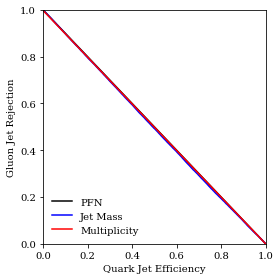

In [16]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()
